In [1]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

def Customize_EfficientSU2(number_qubits, number_of_subcircuit):
    """
    number_qubits: The amounts of qubits in out system
    number_of_subcircuit: The amounts of subcuirt for parameterized our system
    su2gate: is the gate we want to parameterized with
    insert_barriers: add barriers in our circuit for nice looking
    The function will return the circuit having the parameter and we can update these parameter in our code
    """
    circuit = QuantumCircuit(number_qubits)


    # Use for the 1-qubit case
    if number_qubits == 1:
        theta1 = Parameter(r'$\theta[{}]$'.format(0))
        circuit.ry(theta1, 0)
        theta2 = Parameter(r'$\theta[{}]$'.format(1))
        circuit.rz(theta2, 0)
        circuit.barrier()

        for i in range(number_of_subcircuit):
            theta1 = Parameter(r'$\theta[{}]$'.format(2*i+2))
            circuit.ry(theta1, 0)
            theta2 = Parameter(r'$\theta[{}]$'.format(2*i+3))
            circuit.rz(theta2, 0)

            if i != number_of_subcircuit - 1:
                circuit.barrier()


        return circuit


    def add_subcircuit(circuit, stop_barrier):
        sub_circuit = QuantumCircuit(number_qubits)
        number_parameter = circuit.num_parameters

        sub_circuit.barrier()

        # sub_circuit.cx(number_qubits-1, 0)
        for i in (range(number_qubits-1)):
            sub_circuit.cx(i, i+1)

        # sub_circuit.cx(number_qubits-1, 0)

        sub_circuit.barrier()


        # hmm cause of lack of my knowledge, I will work with the RealAmplitudes ansat, circular entanglement
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_parameter+i))
            sub_circuit.ry(theta, i)
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_qubits+number_parameter+i))
            sub_circuit.rz(theta, i)


        # if stop_barrier != number_of_subcircuit-1:
        #     sub_circuit.barrier()

        # sub_circuit.draw('mpl', style = 'iqx')

        return sub_circuit


    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(i))
        circuit.ry(theta, i)

    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(number_qubits+i))
        circuit.rz(theta, i)

    for i in range(number_of_subcircuit):
        circuit = circuit.compose(add_subcircuit(circuit, i))

    return circuit


def Customize_RealAmplidues(number_qubits, number_of_subcircuit):
    """
    number_qubits: The amounts of qubits in out system
    number_of_subcircuit: The amounts of subcuirt for parameterized our system
    su2gate: is the gate we want to parameterized with
    insert_barriers: add barriers in our circuit for nice looking
    The function will return the circuit having the parameter and we can update these parameter in our code
    """
    circuit = QuantumCircuit(number_qubits)


    # Use for the 1-qubit case
    if number_qubits == 1:

        for i in range(0, number_qubits):
                theta = Parameter(r'$\theta[{}]$'.format(i))
                circuit.ry(theta, i)
                circuit.barrier()
        for i in range(number_of_subcircuit):
            theta1 = Parameter(r'$\theta[{}]$'.format(1+i))
            circuit.ry(theta1, 0)
            if i != number_of_subcircuit - 1:
                circuit.barrier()


        return circuit


    def add_subcircuit(circuit, stop_barrier):
        sub_circuit = QuantumCircuit(number_qubits)
        number_parameter = circuit.num_parameters

        sub_circuit.barrier()

        # sub_circuit.cx(number_qubits-1, 0)
        for i in (range(number_qubits-1)):
            sub_circuit.cx(i, i+1)

        sub_circuit.barrier()


        # hmm cause of lack of my knowledge, I will work with the RealAmplitudes ansat, circular entanglement
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_parameter+i))
            sub_circuit.ry(theta, i)


        # if stop_barrier != number_of_subcircuit-1:
        #     sub_circuit.barrier()

        # sub_circuit.draw('mpl', style = 'iqx')

        return sub_circuit


    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(i))
        circuit.ry(theta, i)

    # for i in range(0, number_qubits):
    #     theta = Parameter(r'$\theta[{}]$'.format(number_qubits+i))
    #     circuit.rz(theta, i)

    for i in range(number_of_subcircuit):
        circuit = circuit.compose(add_subcircuit(circuit, i))

    return circuit

In [2]:
# Parameter shift rule
def Customize_Parameter_Shift_Rule(operator, parameter, eta, ansatz, shots, backend, interation, estimator):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update
    eta: learning rate
    """
    number_of_parameters = len(parameter)
    grad = np.zeros(number_of_parameters)


    for i in range(len(operator)):
        grad_func = np.zeros(number_of_parameters)
        for j in range(number_of_parameters):
            plus_parameter = parameter.copy()
            plus_parameter[j] += np.pi/2
            minus_parameter = parameter.copy()
            minus_parameter[j] -= np.pi/2
            plus_circuit = ansatz.bind_parameters({theta: plus_parameter[k] for k, theta in enumerate(ansatz.parameters)})
            minus_circuit = ansatz.bind_parameters({theta: minus_parameter[k] for k, theta in enumerate(ansatz.parameters)})
            # print(plus_circuit)
            # print(minus_circuit)
            grad_func[j] = (eta)*operator.coeffs.real[i]*(estimator.run(plus_circuit, operator.primitive._pauli_list[i], shots=shots).result().values[0] - estimator.run(minus_circuit, (operator.primitive._pauli_list[i]), shots=shots).result().values[0])/2

        grad = np.add(grad, grad_func)

    return np.array(grad)


def Customize_Variational_Quantum_EigenSolver(operator, optimize, interation, ansatz, eta, initial_point, shots, backend, estimator, callback):
    """
    operator: the pauli matrix
    interation: number of interations
    ansatz: the ansatz for perparing the parameterized circuit
    eta: learning rate
    initial_points: random sample of number uses at the beggining of running
    shots: number of shots
    backend: the backend
    """

    energy = []

    internal_initial_point = initial_point.copy()

    b = np.zeros(ansatz.num_parameters)

    for i in range(interation):
        print(f'{internal_initial_point} ---------')
        internal_anstaz = ansatz.bind_parameters({theta: internal_initial_point[k] for k, theta in enumerate(ansatz.parameters)})

        # print(internal_anstaz)
        # Measure the expectation of our hamiltonian
        # internal_energy = 0
        # for j in range(len(operator)):
        #     internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
        #     print(internal_energy)
        internal_energy = estimator.run(internal_anstaz, operator, shots=shots).result().values[0]
            # print( operator.coeffs.real[j])
            # print(operator.primitive._pauli_list[j])
            # print(internal_energy)

            # measure = Measurement('X', internal_anstaz, 10000, backend=Aer.get_backend('qasm_simulator'))[0]*10
            # print(f'///{measure}///')

        # print(f'{internal_initial_point} hmm')

        energy.append(internal_energy)
        print(internal_energy)


        if callback is not None:
            callback(internal_initial_point, internal_energy)

        # Update the parameter points
        # if optimize == Customize_Quantum_Natural_Graident_Descent:
        #     super_circuit = Seperate_Circuit_Apart(ansatz)
        #     a = np.add(optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation, super_circuit), -0.9*b)
        #     # b = a.copy()
        #     internal_initial_point =  np.subtract(internal_initial_point,a)
        #     # print(internal_energy)

        #     continue

        a = optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation, estimator)
        # a = np.add(optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation), -0.9*b)
        # b = a.copy()
        internal_initial_point =  np.subtract(internal_initial_point,a)
        # print(f'a: {a}')

        # print(internal_energy)

    if callback is None:
        return energy


from qiskit.opflow import Z, I, X
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
import time

# Ising hamiltonian
def Ising_hamiltonian(num_qubits, h):
    hamiltonian = 0

    if num_qubits == 1:
        hamiltonian = Z + h*X
        return hamiltonian.reduce()

    if num_qubits == 2:
        hamiltonian = Z^Z
        hamiltonian += h*X^I
        hamiltonian += h*I^X
        return hamiltonian.reduce()



    hamiltonian += Z^(I^(num_qubits-2))^Z
    for i in range(num_qubits-1):
        hamiltonian += (I^(i))^(Z^Z)^(I^(num_qubits-2-i))

    for i in range(num_qubits):
        hamiltonian += h*((I^(i))^(X)^(I^(num_qubits-1-i)))

    return hamiltonian.reduce()

In [3]:
# from qiskit.opflow import Z, I, X
# from qiskit.quantum_info import Pauli, SparsePauliOp
# from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
# import time

# start_time = time.time()

# num_qubits = 1 # (N_p = num_qubit-1)


# intermediate_info = {
#     'parameters': [],
#     'energy': [],
# }

# def callback(parameters, energy):
#     intermediate_info['parameters'].append(parameters)
#     intermediate_info['energy'].append(energy)

# hamiltonian = Ising_hamiltonian(1,2)
# hamiltonian = (hamiltonian^I^I^I^I).reduce()

# ansatz = Customize_EfficientSU2(1, 0)
# ansatz_opt = transpile(ansatz, backend=backend)
# # ansatz_opt.draw()

# interation = 20
# hamiltonian = Ising_hamiltonian(1,2)
# # hamiltonian = (hamiltonian^I^I^I^I).reduce()

# initial_point = np.zeros(ansatz_opt.num_parameters)+0.5

# backend = provider.get_backend("ibmq_qasm_simulator")
# eta = 0.1
# shots = 8192

# # from qiskit import Aer

# energy = Customize_Variational_Quantum_EigenSolver(hamiltonian, Customize_Parameter_Shift_Rule, interation, ansatz_opt, eta, initial_point, shots, backend, callback=None)

# print(time.time() - start_time)

# # print(VQE_runtime[-1])

# Test

In [8]:
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account(token='081573a72593a0b5c2ffb1bfa2128ac29452fee91b33f7cf134b4c9b49353d495322f295acbc04200e3be4124025261972d3c8568d7d086e67178403d0ee110b', overwrite=True)
# lima = provider.get_backend("ibmq_lima")

In [12]:
ansatz_opt = transpile(Customize_RealAmplidues(2, 1), backend=backend, initial_layout=q_layout)

ansatz_opt.draw('mpl', style = 'iqx')

In [14]:
from qiskit_ibm_runtime import Session, Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, transpile
import numpy as np

provider = IBMProvider()
# backend = provider.get_backend("ibmq_qasm_simulator")

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_lima")

# backend = provider.get_backend("ibmq_qasm_simulator")


intermediate_info = {
    'parameters': [],
    'energy': [],
}

def callback(parameters, energy):
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)


with Session(backend=backend): #, max_time="8h"
    estimator = Estimator()

    #5.1 ansatz =
    q_layout = [0,1]
    ansatz_opt = transpile(Customize_RealAmplidues(2, 1), backend=backend, initial_layout=q_layout)
    # print(ansatz_opt)
    # ansatz_opt = transpile(Customize_EfficientSU2(1, 0), backend=backend)
    # ansatz_opt.draw()

    interation = 7
    hamiltonian = Ising_hamiltonian(2,2)
    hamiltonian = (I^I^I^hamiltonian).reduce()

    eta = 0.2

    shots = 40000
    # hamiltonian = (hamiltonian^I^I^I^I).reduce()

#     initial_point = np.zeros(ansatz_opt.num_parameters)+0.5
    
    initial_point = np.array([0.80018395, -1.83648008, -0.73304282, 0.15711315])


    energy = Customize_Variational_Quantum_EigenSolver(hamiltonian, Customize_Parameter_Shift_Rule, interation, ansatz_opt, eta, initial_point, shots, backend, estimator, callback)


[ 0.80018395 -1.83648008 -0.73304282  0.15711315] ---------


runtime_job._start_websocket_client:WARNING:2023-07-03 01:19:37,825: An error occurred while streaming results from the server for job cigrtpup0prapsh6mhe0:
Traceback (most recent call last):
  File "d:\Users\DELL\anaconda3\lib\site-packages\qiskit_ibm_runtime\runtime_job.py", line 503, in _start_websocket_client
    self._ws_client.job_results()
  File "d:\Users\DELL\anaconda3\lib\site-packages\qiskit_ibm_runtime\api\clients\runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "d:\Users\DELL\anaconda3\lib\site-packages\qiskit_ibm_runtime\api\clients\base.py", line 230, in stream
    raise WebsocketError(error_message)
qiskit_ibm_runtime.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection.'



-4.043618681686924


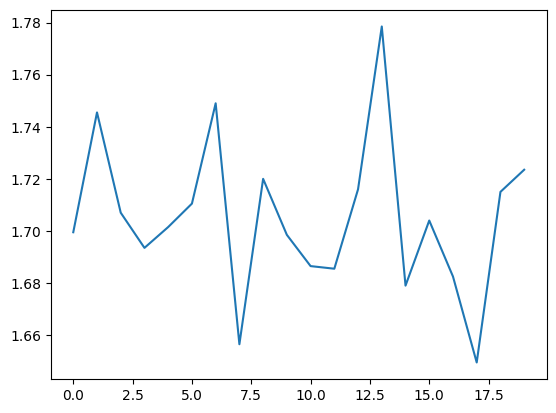

In [ ]:
import matplotlib.pyplot as plt
plt.plot(energy)

In [17]:
print((intermediate_info['energy']))

[-0.9100922917207371, -2.274116469038208, -2.874361586638831, -3.109313899010932, -3.1383436619718306, -3.1962176455096127, -3.176076943072524, -3.1869167544783985, -3.1410474655575773, -3.1874060822898027, -3.147916783398184, -3.1703811616954476, -3.1584806722689076, -3.1685836373110994]


In [16]:
intermediate_info['parameters']

[array([1.91359098, 4.52503097]),
 array([2.06491969, 3.96925581]),
 array([2.05323938, 3.58864739]),
 array([1.97796581, 3.36790158]),
 array([1.92493436, 3.25202545]),
 array([1.89419995, 3.19016349]),
 array([1.89288596, 3.16860367]),
 array([1.89283529, 3.15697702]),
 array([1.89651893, 3.15337465]),
 array([1.88774032, 3.1500057 ]),
 array([1.87997116, 3.14765817]),
 array([1.88526257, 3.14764184]),
 array([1.88529172, 3.14598673]),
 array([1.89172839, 3.15058531])]

NameError: name 'data' is not defined